# Explore RAST Metadata

I have abstracted this out because we need some new functions, and so I want a clean notebook. Will merge with the RAST notebook later!

In [1]:
import os
import sys

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from PhiSpyAnalysis import theils_u, DateConverter, printmd
from PhiSpyAnalysis import read_phages, read_gtdb, read_checkv, read_base_pp, read_categories, read_metadata, read_gbk_metadata

from scipy.stats import pearsonr, f_oneway, entropy
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse, ParserError
import pytz

import subprocess
import gzip


## Read the metadata

We just use the small file for development, and then clean up a few known issues

In [4]:
use_small_data=False
metadf = read_metadata(use_small_data=use_small_data)

In [5]:
metadf['isolation_date']

0                 NaN
1                 NaN
2                 NaN
3                 NaN
4                 NaN
             ...     
320171    2015.291581
320172            NaN
320173    2014.292266
320174    2014.292266
320175            NaN
Name: isolation_date, Length: 320176, dtype: float64

# Theil's U

This work comes from [The Search For Categorical Correlation](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) and [The Dython Library](https://github.com/shakedzy/dython) but I have abstracted and simplified it here for my use

_Note_ I have now abstracted this into a class for use in the code

In [6]:
theils_u(metadf['isolation_country'], metadf['geographic_location'])

0.9721908947957727

In [7]:
pd.set_option('display.max_rows', 1000)
metadf[metadf['isolation_site'].notnull() & metadf['other_clinical'].notnull()][['isolation_site', 'other_clinical']]

,isolation_site,other_clinical
14557,Respiratory,hospital location:ICU
14558,Urine,hospital location:non-ICU
15424,Urine,hospital location:non-ICU
15426,Urine,hospital location:non-ICU
15430,Urine,hospital location:non-ICU
15431,Urine,hospital location:non-ICU
15432,Tissue,hospital location:non-ICU
15433,Urine,hospital location:non-ICU
15434,Urine,hospital location:non-ICU
15440,Respiratory,hospital location:non-ICU


In [8]:
if False:
    hm = pd.DataFrame(index=metadf.columns, columns=metadf.columns, dtype=float)
    for i in range(len(metadf.columns)):
        for j in range(len(metadf.columns)):
            hm.iloc[i,j] = theils_u(metadf.iloc[:,i], metadf.iloc[:,j])
    sns.heatmap(hm)

In [9]:
acccol = 'assembly_accession'
interesting_cols = [acccol, 'isolation_site', 'geographic_location', 'isolation_country', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'isolation_date']

hmi = pd.DataFrame(index=interesting_cols, columns=interesting_cols, dtype=float)
for i,j in enumerate(interesting_cols):
    for x,y in enumerate(interesting_cols):
        hmi.iloc[i,x] = theils_u(metadf.loc[:,j], metadf.loc[:,y])

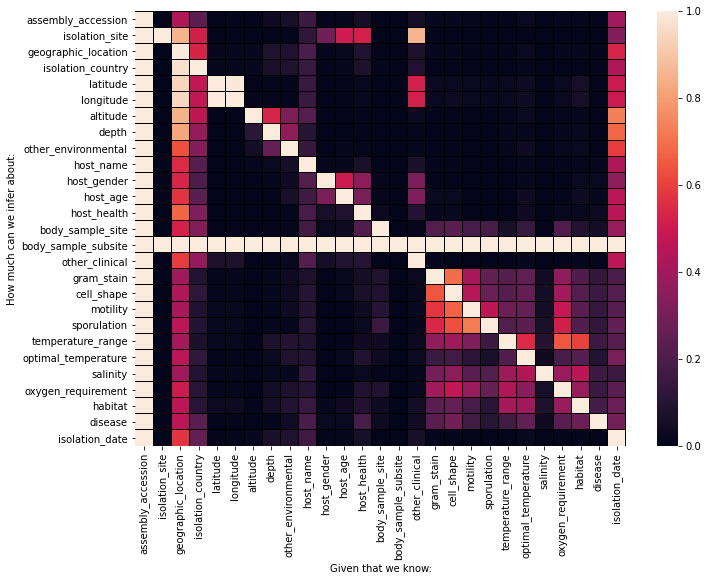

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
# sns.heatmap(hmi, cmap='Blues', ax=ax)
ax = sns.heatmap(hmi, linecolor='k', linewidths=0.01, ax=ax)
t = ax.set_ylabel("How much can we infer about:")
t = ax.set_xlabel("Given that we know:")

In [11]:
col1 = 'other_clinical'
col2 = 'isolation_site'
u1 = theils_u(metadf.loc[:,col1], metadf.loc[:,col2])
u2 = theils_u(metadf.loc[:,col2], metadf.loc[:,col1])

print(f"{col1} vs {col2} {u1}")
print(f"{col2} vs {col1} {u2}")

if u1 > u2:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col2} we have a lot of information about the {col1} ")
    print(f"but knowing the {col1} does not inform us about the {col2}")
else:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col1} we have a lot of information about the {col2} ")
    print(f"but knowing the {col2} does not inform us about the {col1}")
     

other_clinical vs isolation_site 0.005078095497709224
isolation_site vs other_clinical 0.8588933773243432
Theils U is probability of X given Y
This means that knowing the other_clinical we have a lot of information about the isolation_site 
but knowing the isolation_site does not inform us about the other_clinical


In [12]:
metadf[metadf['isolation_site'] == 'Sputum'].groupby(['other_clinical', 'isolation_site']).size()

other_clinical                                         isolation_site
comorbidity:HIV negative;treatment course:adm          Sputum            39
comorbidity:HIV positive;treatment course:adm          Sputum            15
comorbidity:MDR-TB, HIV negative;treatment course:adm  Sputum            25
comorbidity:MDR-TB, HIV positive;treatment course:adm  Sputum             2
comorbidity:MDR_TB, HIV negative;treatment course:adm  Sputum             1
hospital location:non-ICU                              Sputum             1
treatment course:adm                                   Sputum             1
dtype: int64

In [13]:
metadf.groupby(['isolation_site', 'other_clinical']).size()

isolation_site                  other_clinical                                       
Abdominal surgical drain fluid  hospital location:non-ICU                                 1
Bile (fluid)                    hospital location:non-ICU                                 1
Blood                           collection service:CMED                                   1
                                collection service:OMED                                   1
Blood culture                   specimen location:INP;collection service:SURG             1
Bronchoalveolar lava            specimen location:INP;collection service:TRAUM            1
Fluid Peri Panceatic            hospital location:OP                                      1
Respiratory                     collection service:SURG                                   1
                                hospital location:ICU                                     1
                                hospital location:non-ICU                             

In [14]:
metadf.groupby(['other_clinical', 'isolation_site']).size()

other_clinical                                         isolation_site                
collection service:CMED                                Blood                              1
collection service:OMED                                Blood                              1
collection service:ORTHO                               Wound                              1
collection service:SURG                                Respiratory                        1
                                                       Wound                              1
collection service:UROLOGY                             Urine                              1
comorbidity:HIV negative;treatment course:adm          Sputum                            39
comorbidity:HIV positive;treatment course:adm          Sputum                            15
comorbidity:MDR-TB, HIV negative;treatment course:adm  Sputum                            25
comorbidity:MDR-TB, HIV positive;treatment course:adm  Sputum                         

In [15]:
col1 = 'geographic_location'
col2 = 'isolation_country'
tmp = metadf[(metadf[col1].notnull()) & (metadf[col2].notnull())]

tmp[[col1, col2]]

,geographic_location,isolation_country
1,Canada: Quebec,Canada
4,Iceland,Iceland
5,New York State,United States
7,"West Palm Beach, Florida",United States
10,Denmark: Aarhus,Denmark
...,...,...
320167,"USA:Seattle, Washington",United States
320170,United Kingdom,United Kingdom
320171,United Kingdom,United Kingdom
320173,United Kingdom,United Kingdom


In [16]:
col1 = 'geographic_location'
col2 = 'isolation_country'
u1 = theils_u(metadf.loc[:,col1], metadf.loc[:,col2])
u2 = theils_u(metadf.loc[:,col2], metadf.loc[:,col1])

print(f"{col1} vs {col2} {u1}")
print(f"{col2} vs {col1} {u2}")

if u1 > u2:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col2} we have a lot of information about the {col1} ")
    print(f"but knowing the {col1} does not inform us about the {col2}")
else:
    print("Theils U is probability of X given Y")
    print(f"This means that knowing the {col1} we have a lot of information about the {col2} ")
    print(f"but knowing the {col2} does not inform us about the {col1}")
    

geographic_location vs isolation_country 0.5326628369307002
isolation_country vs geographic_location 0.9721908947957727
Theils U is probability of X given Y
This means that knowing the geographic_location we have a lot of information about the isolation_country 
but knowing the isolation_country does not inform us about the geographic_location


In [17]:
col1 = 'geographic_location'
col2 = 'isolation_country'
counts12 = {}
counts21 = {}
for index, row in metadf.iterrows():
    gl = row[col1]
    ic = row[col2]
    
    if gl not in counts12:
        counts12[gl] = {}
    counts12[gl][ic] = counts12[gl].get(ic, 0) + 1
    
    if ic not in counts21:
        counts21[ic] = {}
    counts21[ic][gl] = counts21[ic].get(gl, 0) + 1

c12s = 0
c12m = 0
c21s = 0
c21m = 0
for k in counts12:
    if len(counts12[k]) == 1:
        c12s += 1
    else:
        c12m += 1

for k in counts21:
    if len(counts21[k]) == 1:
        c21s += 1
    else:
        c21m += 1

print(f"Given {len(counts12.keys()):,} {col1} you will have {c12s:,} ({c12s/len(counts12.keys())*100:.2f} %) single {col2}")
print(f"Given {len(counts12.keys()):,} {col1} you will have {c12m:,} ({c12m/len(counts12.keys())*100:.2f} %) multiple {col2}")
print(f"\nGiven {len(counts21.keys()):,} {col2} you will have {c21s:,} ({c21s/len(counts21.keys())*100:.2f} %) single {col1}")
print(f"Given {len(counts21.keys()):,} {col2} you will have {c21m:,} ({c21m/len(counts21.keys())*100:.2f} %) multiple {col1}")

Given 13,967 geographic_location you will have 13,817 (98.93 %) single isolation_country
Given 13,967 geographic_location you will have 150 (1.07 %) multiple isolation_country

Given 281 isolation_country you will have 77 (27.40 %) single geographic_location
Given 281 isolation_country you will have 204 (72.60 %) multiple geographic_location
